# Introduction

This notebook explores different cost functions to mine union tripples from fuse.

In [3]:
import os
%load_ext autoreload
%autoreload 2

In [4]:
import io
import tarfile
import pandas as pd
import numpy as np
from tqdm import tqdm

In [16]:
from tacomin.compress import components

In [6]:
# Suppress warning for xlrd
import warnings
# Filter all warning that start with "WARNING"
warnings.filterwarnings('ignore')

In [7]:
# pass over all files and build summary
file = 'experiments/results/filtered2.tar.gz'
# Get list of files in tar archive
tar = tarfile.open(file)

In [8]:
all_members = tar.getmembers()
len(all_members)

161321

In [9]:
from pickle import load
print('Loading')
with open('experiments/results/meta.pkl', 'rb') as f:
    vocab, words_member = load(f)
print('Adding')
words_member = [('cc-binaries/' + m, s) for m, s in words_member]
len(words_member), len(vocab)

Loading
Adding


(279699, 8591565)

In [10]:
if isinstance(words_member[0], tarfile.TarInfo):
    index_name_map = {i: k for i, k in enumerate(words_member)}
else:
    # Map back to filenames
    index_name_mapn = {i: k for i, k in enumerate(words_member)}
    # Map back to members
    member_name_map = {member.name: member for member in all_members}
    index_name_map = {i: (member_name_map[filek], sheetk) for i, (filek, sheetk) in index_name_mapn.items()}

In [11]:
k = 20

In [12]:
df = pd.read_parquet('experiments/results/ftripples.parquet')
df = df[df.score > 0]
df.shape

(553565, 10)

<Axes: >

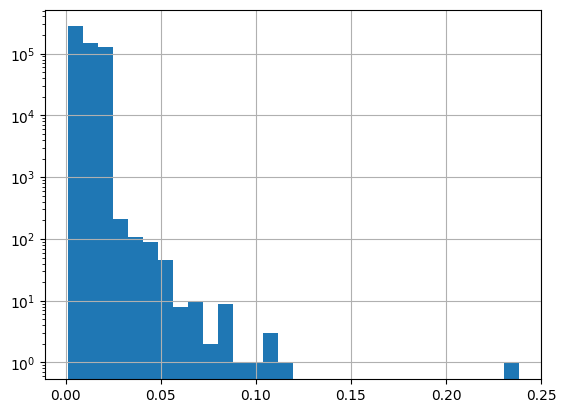

In [13]:
# Log
df.score.iloc[0:100_000_000].hist(bins=30, log=True)

In [17]:
# Now get the highest scoring row per component
dfc = components(df, 1000)
dfc.shape

Number of connected components: 262715
Component labels for each node: [     0      1      2 ... 262713 262714     88]


(29, 11)

In [92]:
def display_sheets(frm, to):
    # Load and display
    dfso = []
    for n, (if1, if2, if3, score, *als) in dfc.iloc[frm:to].iterrows():
        f1 = (index_name_map[if1])
        f2 = (index_name_map[if2])
        f3 = (index_name_map[if3])
        print(f'{frm}:')
        print(f'  index: {n}')
        print(f'  score: {score}')
        print(f'  als: {[int(a) for a in als]}')
        fstuples = [(f, s) for f, s in [f1, f2, f3]]
        print(f'  files: {[(f.name, s) for f, s in fstuples]}')
        dfs = []
        for i, (f, s) in enumerate(fstuples):
            buffer = tar.extractfile(f)
            df = pd.read_excel(io.BytesIO(buffer.read()), sheet_name=s, header=None, index_col=None)
            dfs.append(df)
        print(f'  shapes: {[df.shape for df in dfs]}')

        for df in dfs:
            display(df)
            print()
        dfso.append(dfs)
    return dfso

n = 0
df1, df2, df3 = display_sheets(n, n+1)[0]

0:
  index: 132
  score: 0.23817812022131174
  als: [115, 69, 79, 274, 199, 197, 132]
  files: [('cc-binaries/34b4af4e-68c1-4031-ad20-1b056bed0bb5', 0), ('cc-binaries/136c6594-d14e-41f6-a1fb-2f581b66aa9f', 8), ('cc-binaries/26c8bb06-0e49-4bd1-b447-a3c1ae19a087', 6)]
  shapes: [(5392, 5), (5396, 2), (5517, 2)]


,0,1,2,3,4
0,Код по НКПД 2011,Наименование по НКПД 2011,Код по НКПД 2005,Наименование по НКПД 2005,съвпадение
1,31547001,Авиодиспечер,31447001,Авиодиспечер,да
2,35223025,"Авиодиспечер, аеронавигационни съобщения",няма код,няма код,не
3,31543002,"Авиодиспечер, въздушно обслужване",31443002,"Авиодиспечер, въздушно обслужване",да
4,21446048,Авиоинженер,21496040,Авиоинженер,да
...,...,...,...,...,...
5387,71232004,Шпакловчик,71332004,Шпакловчик,да
5388,73212037,"Щанцьор, изработка на шанцформи",73432026,"Щанцьор, изработка на шанцформи",да
5389,31524017,Щурман,31424015,Щурман,да
5390,26197005,Юрисконсулт,24297007,Юрисконсулт,да


,0,1
0,Код по НКПД 2011,Наименование по НКПД 2011
1,31547001,Авиодиспечер
2,35223025,"Авиодиспечер, аеронавигационни съобщения"
3,31543002,"Авиодиспечер, въздушно обслужване"
4,21446048,Авиоинженер
...,...,...
5391,NaN,NaN
5392,NaN,NaN
5393,NaN,NaN
5394,NaN,NaN


,0,1
0,Код по НКПД,Наименование
1,31447001,Авиодиспечер
2,31443002,"Авиодиспечер, въздушно обслужване"
3,21496040,Авиоинженер
4,22217078,Авиолекар
...,...,...
5512,NaN,NaN
5513,NaN,NaN
5514,NaN,NaN
5515,NaN,NaN


In [94]:
!ls -lah experiments/transformations/0

total 1040
drwxr-xr-x@ 5 dirkocoetsee  staff   160B Mar 18 14:28 .
drwxr-xr-x@ 4 dirkocoetsee  staff   128B Mar 18 14:28 ..
-rw-r--r--@ 1 dirkocoetsee  staff   263K Mar 18 14:28 0.parquet
-rw-r--r--@ 1 dirkocoetsee  staff   132K Mar 18 14:28 1.parquet
-rw-r--r--@ 1 dirkocoetsee  staff   119K Mar 18 14:28 2.parquet


In [93]:

# Save in experiments/transformations/{n}.parquet
#import os
os.makedirs(f'experiments/transformations/{n}', exist_ok=True)
# Convert column names to string
for df in [df1, df2, df3]:
    df.columns = [str(c) for c in df.columns]
    # Convert all values to string
    for c in df.columns:
        df[c] = df[c].apply(str)
df1.to_parquet(f'experiments/transformations/{n}/0.parquet')
df2.to_parquet(f'experiments/transformations/{n}/1.parquet')
df3.to_parquet(f'experiments/transformations/{n}/2.parquet')


157 310 26
0 137 0


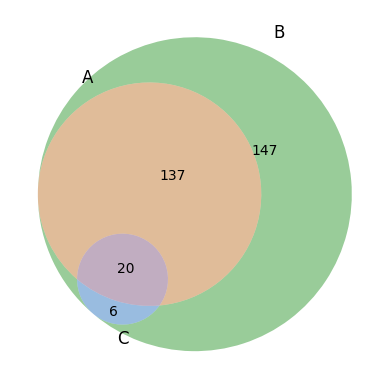

In [264]:
#r = setan(df1, df2, df3, [0,1], [1,0], [1,0])
#setan(_r(df1, 0), _r(df2, 0), _r(df3, 3), [0, 1], [0, 1], [3, 5])

r = setan(df1, df2, df3, 0, 0, 0, lower=True)
r[0]



In [233]:
a,b,c=r[1]
a-b#, a&b, a&c, a&b&c

{('CNA',)}

In [266]:
match(df1, df2, df3, 0.001, lower=True)

0
  0 ~ 0 (157/157=100% 157/310=51%)
1
  0 ~ 0 (20/157=13% 20/26=77%)
2
  0 ~ 0 (26/310=8% 26/26=100%)
  2 ~ 10 (1/158=1% 1/17=6%)
  3 ~ 7 (1/304=0% 1/3=33%)
  3 ~ 10 (1/304=0% 1/17=6%)
  3 ~ 13 (1/304=0% 1/2=50%)


In [185]:
display(df3.head(40).tail(10))

,0,1,2,3,4,5,6,7,8
30,Board (515),Davis,1990-05-01 00:00:00,X,NaN,0.0004,0.0004,NaN,NaN
31,Voted (510),Davis,1979-11-27 00:00:00,NaN,X,NaN,NaN,NaN,NaN
32,Voted (510),Davis,1980-10-02 00:00:00,X,NaN,0.0006,NaN,NaN,NaN
33,Voted (510),Davis,1993-05-18 00:00:00,X,NaN,0.001,NaN,0.000400 added to the 10-2-80 Levy.,NaN
34,Voted (510),Davis,1997-05-06 00:00:00,X,NaN,0.0008,0.0018,NaN,NaN
35,DUCHESNE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,Board (515),Duchesne,2000-01-06 00:00:00,X,NaN,0.0004,0.0004,NaN,NaN
37,Voted (510),Duchesne,1962,NaN,X,NaN,NaN,NaN,NaN
38,Voted (510),Duchesne,1990-11-09 00:00:00,NaN,X,NaN,NaN,NaN,NaN
39,Voted (510),Duchesne,1993-05-11 00:00:00,X,NaN,0.0008,0.0008,NaN,NaN


In [245]:
def match(d1, d2, d3, thresh=0.5, lower=False):
    # For each column in d1, calculate overlap with all columns in d2 (d3) and
    # list any with > 50%
    def _prep(val):
        if lower:
            return val.lower()
        return val
    for di, (da, db) in enumerate([(d1, d2), (d1, d3), (d2, d3)]):
        print(di)
        for c1 in range(len(da.columns)):
            for c2 in range(len(db.columns)):
                a = set(_prep(str(v)[:20]) for v in da.iloc[:, c1])
                b = set(_prep(str(v)[:20]) for v in db.iloc[:, c2])
                la = len(a)
                lb = len(b)
                lab = len(a & b)
                perca = lab / la
                percb = lab / lb
                #print(f'{c1} ~ {c2} ({lab}/{la}={perca:.0%} {lab}/{lb}={percb:.0%})')
                if perca > thresh:
                    # Display as percentage %
                    print(f'  {c1} ~ {c2} ({lab}/{la}={perca:.0%} {lab}/{lb}={percb:.0%})')

In [249]:
from matplotlib_venn import venn3, venn3_circles
def setan(df1, df2, df3, c1, c2, c3, lower=False):
    def _tf(df):
        return df if isinstance(df, pd.DataFrame) else df.to_frame()
    def _prep(val):
        if lower:
            return val.lower()
        return val
    a = set(tuple(_prep(str(e)[:20]) for e in v) for _, v in _tf(df1.iloc[:, c1]).iterrows())
    b = set(tuple(_prep(str(e)[:20]) for e in v) for _, v in _tf(df2.iloc[:, c2]).iterrows())
    c = set(tuple(_prep(str(e)[:20]) for e in v) for _, v in _tf(df3.iloc[:, c3]).iterrows())
    print(len(a), len(b), len(c))
    print(len(a - b), len(a - c), len (a - (b | c)))
    return venn3([a, b, c], ('A', 'B', 'C')), (a, b, c)


In [134]:
def _r(df, c):
    df.iloc[:, c] = df.iloc[:, c].apply(lambda x: x.split('-')[0])
    return df


In [18]:
dfc.shape

(29, 11)

In [19]:
dfc.head()

,i,j,k,score,sa1i,sa2i,inter,denom,denom1,denom2,component
component,,,,,,,,,,,
132,129896.0,252145.0,238757.0,0.238178,115.0,69.0,79.0,274.0,199.0,197.0,132.0
755,98551.0,172408.0,270362.0,0.112303,32.0,35.0,15.0,198.0,241.0,328.0,755.0
31882,218328.0,218329.0,218327.0,0.106933,194.0,11.0,30.0,332.0,308.0,380.0,31882.0
92,22973.0,228256.0,6948.0,0.101843,25.0,19.0,13.0,114.0,79.0,642.0,92.0
1224,255238.0,255239.0,217921.0,0.093114,54.0,19.0,16.0,244.0,85.0,549.0,1224.0


In [ ]:
def rescore(d1, d2, d3):
    # Get all pairs of cells in the same row
    pairs = []
    for d in [d1, d2, d3]:


In [33]:
df1 = dfs[0]
df2 = dfs[2]

In [34]:
# Determine the union of unique strings from both DataFrames
all_values = pd.Index(pd.concat([df1.stack(), df2.stack()]).unique())
# Convert each DataFrame using the same categorical mapping
df1_numeric = df1.apply(lambda col: pd.Categorical(col, categories=all_values).codes)
df2_numeric = df2.apply(lambda col: pd.Categorical(col, categories=all_values).codes)

In [50]:
pair_sets = []
for arr in [df1_numeric.to_numpy(), df2_numeric.to_numpy()]:
    i, j = np.triu_indices(arr.shape[0], k=1)
    #pairs = np.stack((arr[:, i], arr[:, j]), axis=-1)
    pairs = np.stack((arr[i, :], arr[j, :]), axis=-1)
    pairs_flat = pairs.reshape(-1, 2)
    pairs_set = {tuple(pair) for pair in pairs_flat}
    pair_sets.append(pairs_set)

In [51]:
p1, p2 = [(pairs_set) for pairs_set in pair_sets]

In [55]:
#len({p[0] for p in p1} & {p[0] for p in p2})
#len(p1 & p2), len(p1), len(p2), len(p1 | p2), len(p1 & p2) / len(p1 | p2)
len({v for p in p1 & p2 for v in p}), len({v for p in p1 & p2 for v in p}) / len(all_values), len(all_values)

(588, 0.12732784755305326, 4618)

In [44]:
df2

,0,1,2,3,4,5,6
0,HCV FSS household counts from 1/1/10 through 1...,NaN,NaN,NaN,NaN,NaN,NaN
1,HA State,HA Name,Formal HA Name,HA Code,FO Name,FO Code,Number of Households
2,Alabama,Birmingham,Housing Authority of the Birmingham District,AL001,Birmingham Hub Office,4CPH,43
3,Alabama,Mobile,Mobile Housing Board,AL002,Birmingham Hub Office,4CPH,160
4,Alabama,Montgomery,Housing Authority of the City of Montgomery,AL006,Birmingham Hub Office,4CPH,73
...,...,...,...,...,...,...,...
1043,West Virginia,Mingo County Housing Authority,Housing Authority of Mingo County,WV037,Charleston Community Service Center,3CPH,14
1044,West Virginia,Randolph County Housing Authority,Housing Authority of Randolph County,WV045,Charleston Community Service Center,3CPH,6
1045,West Virginia,Greenbrier County Housing Authority,Greenbrier County Housing Authority,WV046,Charleston Community Service Center,3CPH,9
1046,Wyoming,Cheyenne,Housing Authority of the City of Cheyenne,WY002,Denver Hub Office,8APH,27


In [22]:
frm = 0
to = 2

for n, (if1, if2, if3, score, *als) in dfc.iloc[frm:to].iterrows():
    f1 = (index_name_map[if1])
    f2 = (index_name_map[if2])
    f3 = (index_name_map[if3])
    fstuples = [(f, s) for f, s in [f1, f2, f3]]
    dfs = []
    for i, (f, s) in enumerate(fstuples):
        buffer = tar.extractfile(f)
        df = pd.read_excel(io.BytesIO(buffer.read()), sheet_name=s, header=None, index_col=None)
        dfs.append(df)
    #rscore = rescore(dfs[0], dfs[1], dfs[2])
    print(f'{n}: {[df.shape for df in dfs]}')


132: [(5392, 5), (5396, 2), (5517, 2)]
755: [(1003, 2), (401, 5), (1048, 7)]


In [58]:
len(all_members)

161321

In [59]:
m = all_members[0]

In [73]:
# Get all attributes on m
dir(m)
m.get_info()

{'name': 'cc-binaries/25401149-02fa-402e-94f4-c660bcf386b6',
 'mode': 436,
 'uid': 1000,
 'gid': 1000,
 'size': 59164,
 'mtime': 1424924230,
 'chksum': 7876,
 'type': b'0',
 'linkname': '',
 'uname': 'ubuntu',
 'gname': 'ubuntu',
 'devmajor': 0,
 'devminor': 0}

In [76]:
buffer = tar.extractfile(m)
#buffer_s = io.BytesIO(buffer)
#dfs = pd.read_excel(buffer_s, sheet_name=None, header=None, index_col=None)
#import xlrd
#wb = xlrd.open_workbook(file_contents=buffer.read())
import openpyxl
wb = openpyxl.load_workbook(buffer)

In [78]:
wb.path

'/xl/workbook.xml'

In [79]:
wb.properties

<openpyxl.packaging.core.DocumentProperties object>
Parameters:
creator=None, title=None, description=None, subject=None, identifier=None, language=None, created=datetime.datetime(2006, 9, 16, 0, 0), modified=datetime.datetime(2012, 9, 4, 13, 40, 41), lastModifiedBy=None, category=None, contentStatus=None, version=None, revision=None, keywords=None, lastPrinted=None

In [80]:
wb.custom_doc_props

CustomPropertyList containing []